In [1]:
import pandas as pd
import pyathena
import configparser
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Read Athena SQL").getOrCreate()

In [3]:
config = configparser.ConfigParser()
config.read_file(open('credentials.txt'))

In [4]:
KEY = config.get('AWS','KEY')
SECRET = config.get('AWS','SECRET')

In [5]:
# Crie uma conexão com o Athena
conn = pyathena.connect(
    aws_access_key_id=KEY,
    aws_secret_access_key=SECRET,
    region_name='us-east-1',
    s3_staging_dir='s3://caged-bucket/temp-dir/',
)

In [15]:
df_new_caged = pd.read_sql(
    sql='''SELECT data_movimentacao, 
            SUM("admissoes" - "desligamentos") AS saldo
            FROM caged_database.tabela_fato_caged 
            GROUP BY data_movimentacao
            ORDER BY data_movimentacao ASC''',
    con=conn)

C:\Users\bruno\AppData\Local\Temp\ipykernel_12164\393792934.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_new_caged = pd.read_sql(


In [16]:
df_new_caged

,data_movimentacao,saldo
0,2020-01-01,92679
1,2020-02-01,198368
2,2020-03-01,-232316
3,2020-04-01,-902317
4,2020-05-01,-352790
5,2020-06-01,-23111
6,2020-07-01,123297
7,2020-08-01,238124
8,2020-09-01,313564
9,2020-10-01,388938


In [17]:
df_old_caged = pd.read_csv(r'C:\Users\bruno\Documents\Projeto Engenharia de Dados\auxiliar\caged_antigo.csv')

In [18]:
df_old_caged = df_old_caged.drop(["Unnamed: 0", "desligamentos", "admissoes"], axis=1)

In [19]:
df_old_caged 

,data_movimentacao,saldo
0,2010-01-01,181419
1,2010-02-01,209425
2,2010-03-01,266415
3,2010-04-01,305068
4,2010-05-01,298041
...,...,...
115,2019-08-01,121387
116,2019-09-01,157213
117,2019-10-01,70852
118,2019-11-01,99232


In [37]:
consolidado = pd.concat([df_old_caged, df_new_caged])

In [41]:
consolidado['data_movimentacao'] = pd.to_datetime(consolidado['data_movimentacao'])

In [42]:
consolidado.set_index('data_movimentacao', inplace=True)

In [43]:
consolidado

,saldo
data_movimentacao,
2010-01-01,181419
2010-02-01,209425
2010-03-01,266415
2010-04-01,305068
2010-05-01,298041
...,...
2023-01-01,83297
2023-02-01,241785
2023-03-01,195171


<Axes: xlabel='data_movimentacao'>

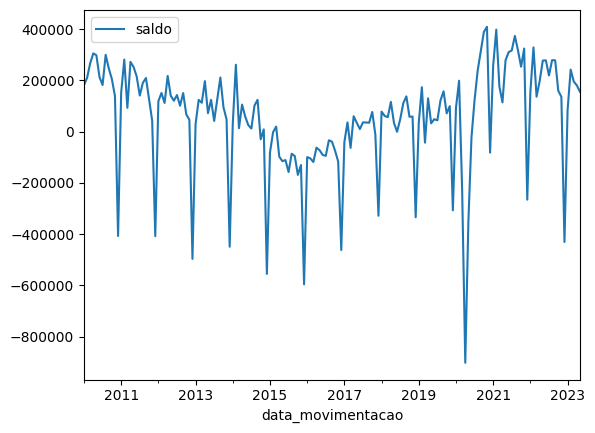

In [44]:
import matplotlib.pyplot as plt
consolidado.plot()

In [45]:
conn.close()

In [46]:
def adf_test(series):
    result= adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', "Number of Observations Used"]
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, rejects the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from matplotlib import pyplot

In [48]:
adf_test(consolidado['saldo'])

ADF Test Statistic:-1.9618337614031442
p-value:0.303554193898646
#Lags Used:12
Number of Observations Used:148
weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


In [49]:
consolidado['Balance First Difference']=consolidado['saldo']-consolidado['saldo'].shift(12)

<Axes: xlabel='data_movimentacao'>

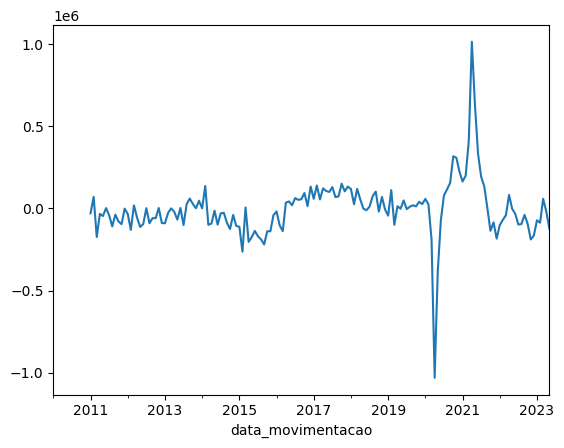

In [50]:
consolidado['Balance First Difference'].plot()

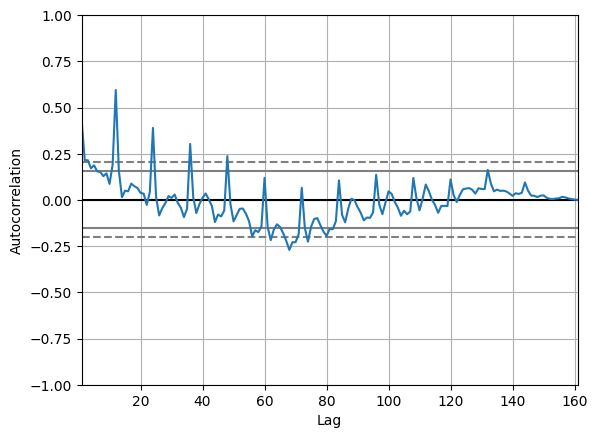

In [51]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(consolidado['saldo'])
plt.show()

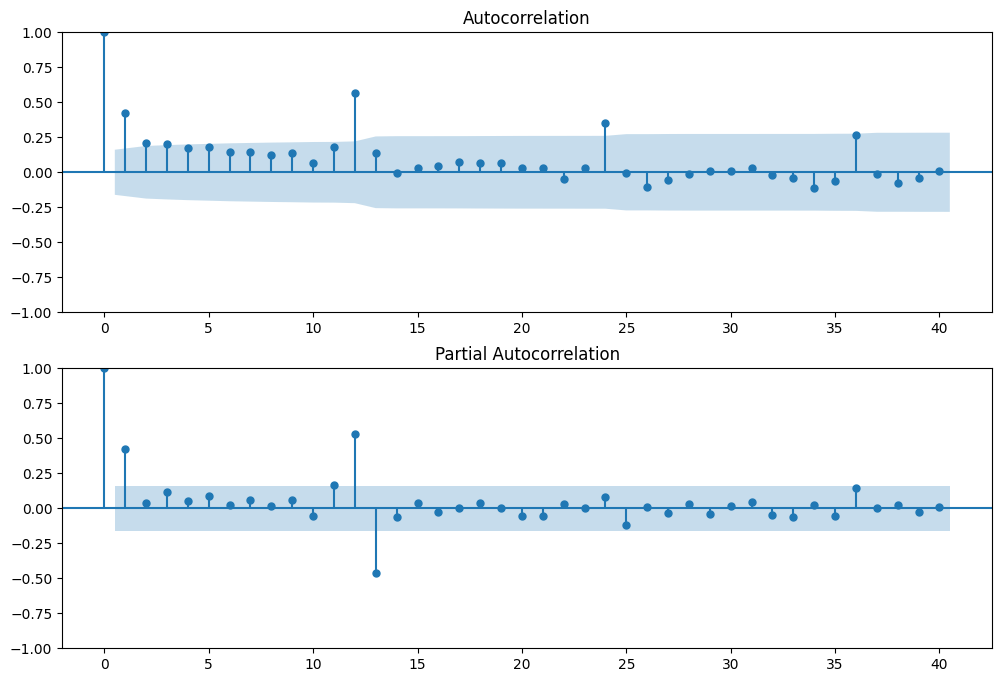

In [52]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(consolidado['saldo'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(consolidado['saldo'].iloc[13:], lags=40, ax=ax2)

In [61]:
model = sm.tsa.statespace.SARIMAX(consolidado['saldo'], order = (1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

C:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: xlabel='data_movimentacao'>

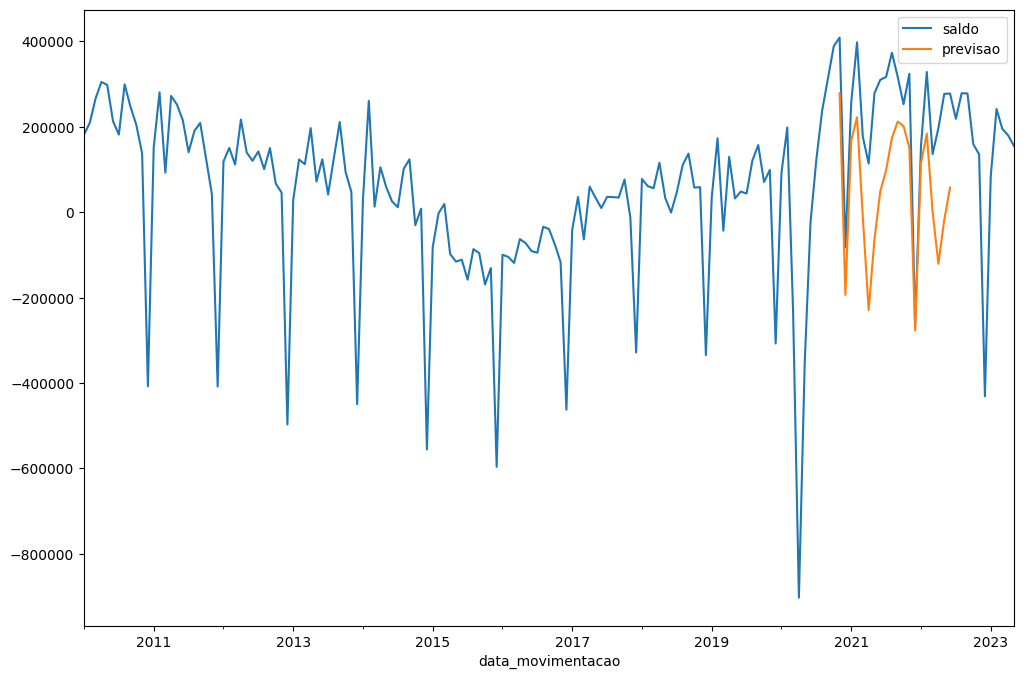

In [62]:
consolidado['previsao'] = result.predict(start=130,end=149,dynamic=True)
consolidado[['saldo','previsao']].plot(figsize=(12,8))

In [63]:
from pandas.tseries.offsets import DateOffset
future_dates = [consolidado.index[-1] + DateOffset(months=x) for x in range (0,36)]

In [64]:
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=consolidado.columns)

In [65]:
future_datest_df.tail()

,saldo,Balance First Difference,previsao
2025-12-01,NaN,NaN,NaN
2026-01-01,NaN,NaN,NaN
2026-02-01,NaN,NaN,NaN
2026-03-01,NaN,NaN,NaN
2026-04-01,NaN,NaN,NaN


In [66]:
previsao_df = pd.concat([consolidado, future_datest_df])

In [74]:
previsao_df['previsao'] = result.predict(start = 159, end = 196, dynamic = True)

<Axes: >

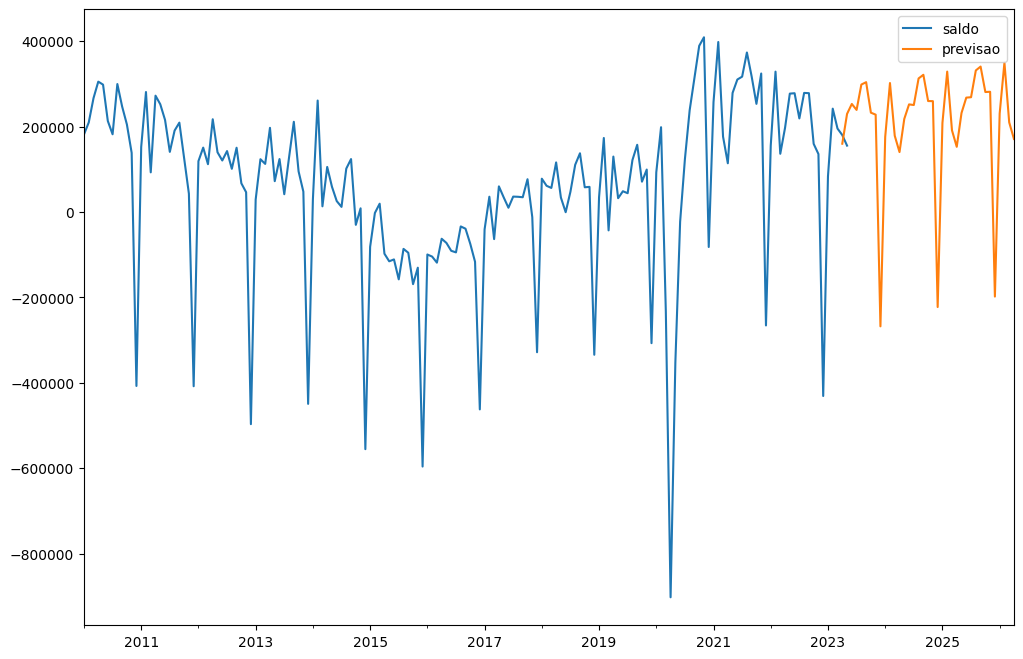

In [80]:
previsao_df[['saldo','previsao']].plot(figsize=(12,8))

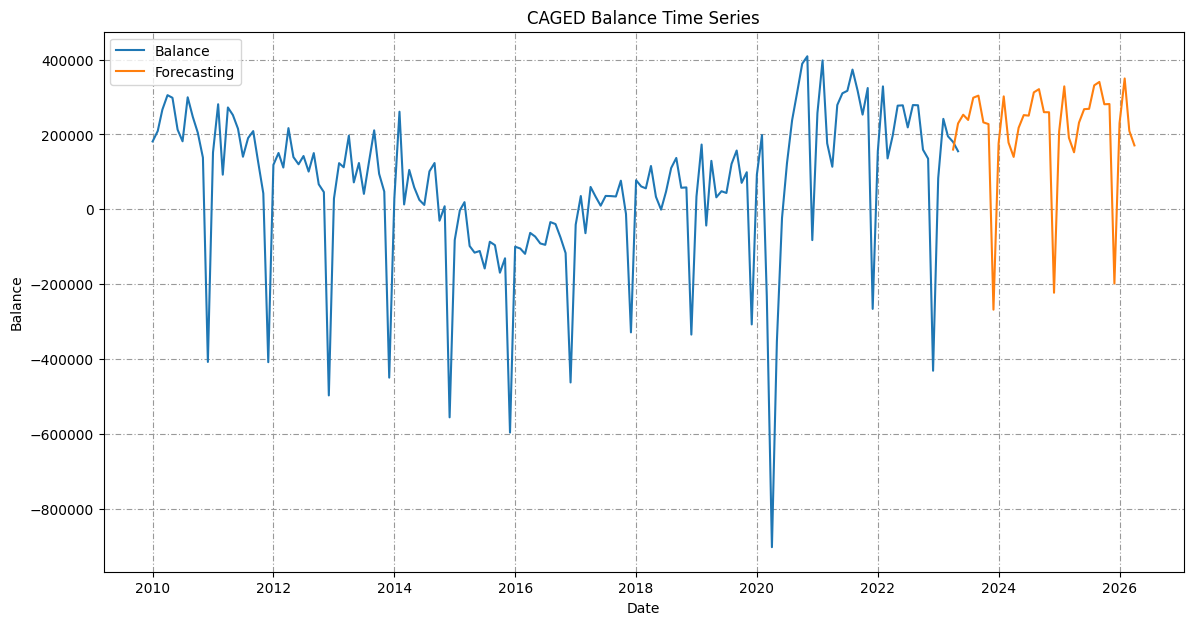

In [84]:
# Matplotlib 
fig_1 = plt.figure(figsize=(12,6), dpi=100)
axes_1 = fig_1.add_axes([0.0, 0.0, 0.9, 0.9])
axes_1.set_xlabel('Date')
axes_1.set_ylabel('Balance')
axes_1.set_title('CAGED Balance Time Series')
axes_1.plot(previsao_df.index, previsao_df[['saldo','previsao']], label=['Balance', 'Forecasting'])
axes_1.legend(loc=0)
axes_1.grid(True, color='0.6', dashes=(5,2,1,2))

In [76]:
previsao_df['previsao'].iloc[161:196]

2023-06-01    252832.897738
2023-07-01    238848.239857
2023-08-01    298257.404382
2023-09-01    303808.925558
2023-10-01    232407.989837
2023-11-01    227783.721168
2023-12-01   -267899.404052
2024-01-01    175761.991426
2024-02-01    301813.755152
2024-03-01    178416.261216
2024-04-01    140120.915325
2024-05-01    217839.059514
2024-06-01    251773.989149
2024-07-01    250381.127444
2024-08-01    312549.270630
2024-09-01    321087.299088
2024-10-01    259630.356361
2024-11-01    259383.585110
2024-12-01   -222694.122323
2025-01-01    208279.616580
2025-02-01    328576.540713
2025-03-01    191159.901765
2025-04-01    152438.597414
2025-05-01    231687.783377
2025-06-01    267626.016346
2025-07-01    268586.207608
2025-08-01    331282.674759
2025-09-01    340384.522462
2025-10-01    280771.275942
2025-11-01    281337.948799
2025-12-01   -198224.954243
2026-01-01    230409.367761
2026-02-01    349645.674784
2026-03-01    209642.516227
2026-04-01    170843.274700
Name: previsao, dtyp